""

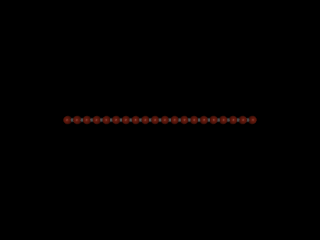

In [19]:
import mujoco
import mediapy as media
import matplotlib.pyplot as plt
import numpy as np
import itertools

# print(mujoco.plugin_list())

xml = """
<mujoco>
  
  <option timestep=".001"/>

<worldbody>
   <composite type="grid" count="20 1 1" spacing="0.045" offset="0 0 1">
  <joint kind="main" damping="0.001"/>
  <tendon kind="main" width="0.01"/>
  <geom size=".02" rgba=".8 .2 .1 1"/>
  <pin coord="1"/>
  <pin coord="13"/>
</composite>
</worldbody>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)

with mujoco.Renderer(model) as renderer:
    mujoco.mj_forward(model, data)
    renderer.update_scene(data)
    media.show_image(renderer.render())

""

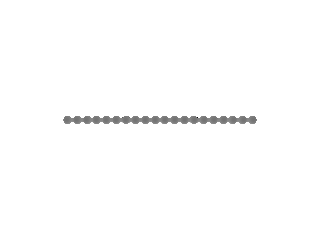

In [20]:
with mujoco.Renderer(model) as renderer:
    # update renderer to render depth
    renderer.enable_depth_rendering()

    # reset the scene
    renderer.update_scene(data)

    # depth is a float array, in meters.
    depth = renderer.render()

    # Shift nearest values to the origin.
    depth -= depth.min()
    # Scale by 2 mean distances of near rays.
    depth /= 2*depth[depth <= 1].mean()
    # Scale to [0, 255]
    pixels = 255*np.clip(depth, 0, 1)

    media.show_image(pixels.astype(np.uint8))

""

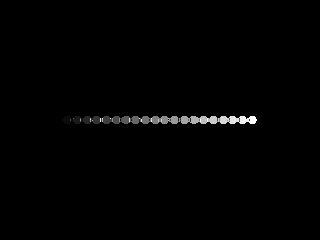

In [21]:
with mujoco.Renderer(model) as renderer:
    renderer.disable_depth_rendering()

    # update renderer to render segmentation
    renderer.enable_segmentation_rendering()

    # reset the scene
    renderer.update_scene(data)

    seg = renderer.render()

    # Display the contents of the first channel, which contains object
    # IDs. The second channel, seg[:, :, 1], contains object types.
    geom_ids = seg[:, :, 0]
    # Infinity is mapped to -1
    geom_ids = geom_ids.astype(np.float64) + 1
    # Scale to [0, 1]
    geom_ids = geom_ids / geom_ids.max()
    pixels = 255*geom_ids
    media.show_image(pixels.astype(np.uint8))

In [22]:
def compute_camera_matrix(renderer, data):
    """Returns the 3x4 camera matrix."""
    # If the camera is a 'free' camera, we get its position and orientation
    # from the scene data structure. It is a stereo camera, so we average over
    # the left and right channels. Note: we call `self.update()` in order to
    # ensure that the contents of `scene.camera` are correct.
    renderer.update_scene(data)
    pos = np.mean([camera.pos for camera in renderer.scene.camera], axis=0)
    z = -np.mean([camera.forward for camera in renderer.scene.camera], axis=0)
    y = np.mean([camera.up for camera in renderer.scene.camera], axis=0)
    rot = np.vstack((np.cross(y, z), y, z))
    fov = model.vis.global_.fovy

    # Translation matrix (4x4).
    translation = np.eye(4)
    translation[0:3, 3] = -pos

    # Rotation matrix (4x4).
    rotation = np.eye(4)
    rotation[0:3, 0:3] = rot

    # Focal transformation matrix (3x4).
    focal_scaling = (1./np.tan(np.deg2rad(fov)/2)) * renderer.height / 2.0
    focal = np.diag([-focal_scaling, focal_scaling, 1.0, 0])[0:3, :]

    # Image matrix (3x3).
    image = np.eye(3)
    image[0, 2] = (renderer.width - 1) / 2.0
    image[1, 2] = (renderer.height - 1) / 2.0
    return image @ focal @ rotation @ translation

In [23]:
with mujoco.Renderer(model) as renderer:
    renderer.disable_segmentation_rendering()
    # reset the scene
    renderer.update_scene(data)

    # Get the world coordinates of the box corners
    box_pos = data.geom_xpos[model.geom('red_box').id]
    box_mat = data.geom_xmat[model.geom('red_box').id].reshape(3, 3)
    box_size = model.geom_size[model.geom('red_box').id]
    offsets = np.array([-1, 1]) * box_size[:, None]
    xyz_local = np.stack(list(itertools.product(*offsets))).T
    xyz_global = box_pos[:, None] + box_mat @ xyz_local

    # Camera matrices multiply homogenous [x, y, z, 1] vectors.
    corners_homogeneous = np.ones((4, xyz_global.shape[1]), dtype=float)
    corners_homogeneous[:3, :] = xyz_global

    # Get the camera matrix.
    m = compute_camera_matrix(renderer, data)

    # Project world coordinates into pixel space. See:
    # https://en.wikipedia.org/wiki/3D_projection#Mathematical_formula
    xs, ys, s = m @ corners_homogeneous
    # x and y are in the pixel coordinate system.
    x = xs / s
    y = ys / s

    # Render the camera view and overlay the projected corner coordinates.
    pixels = renderer.render()
    fig, ax = plt.subplots(1, 1)
    ax.imshow(pixels)
    ax.plot(x, y, '+', c='w')
    ax.set_axis_off()

KeyError: "Invalid name 'red_box'. Valid names: ['G0_0', 'G10_0', 'G11_0', 'G12_0', 'G13_0', 'G14_0', 'G15_0', 'G16_0', 'G17_0', 'G18_0', 'G19_0', 'G1_0', 'G2_0', 'G3_0', 'G4_0', 'G5_0', 'G6_0', 'G7_0', 'G8_0', 'G9_0']"